In [0]:
!pip install bs4
!pip install pythainlp

import requests
import re
import html
import json
from bs4 import BeautifulSoup
# from google.colab import files
import pandas as pd
# import numpy as np

  Running setup.py bdist_wheel for bs4 ... - done
  Stored in directory: /root/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
    100% |████████████████████████████████| 10.3MB 3.1MB/s 
    100% |████████████████████████████████| 276kB 20.1MB/s 
  Running setup.py bdist_wheel for marisa-trie ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/45/24/79/022624fc914f0e559fe8a1141aaff1f9df810905a13fc75d57
Successfully built marisa-trie


In [0]:
def getPostInfosFromContent(content):
    jsonDataArray = re.findall(r'\[\"UFIController\".*?\}\]\}\}\]\]', content)
    posts = {}
    for jsonData in jsonDataArray:
        try:
            data = json.loads(jsonData)[3]
            info = data[2]['feedbacktarget']
            commentsInfo = data[2]['comments']
            comments = []
            for comment in commentsInfo:
                comments.append({
                    'id': comment['id'], #{post_id}_{comment_id}
                    'time': comment['timestamp']['time'],
                    'message': comment['body']['text'],
                    'like': comment['likecount']
                })
                
            posts[info['actorid'] + '_' + info['entidentifier']] = {
                'like': info['likecount'],
                'share': info['sharecount'],
                'comment': info['commentcount'],
                'commentsHighlight': comments
            }
        except:
            continue
    return posts

In [0]:
def getPostsFromContent(content, postInfos):
    soup = BeautifulSoup(content, 'html.parser')
    divs = soup.find_all('div', {'class': '_5pcr userContentWrapper'})
    posts = []
    for div in divs:
        try:
            posts_id = div.find_all('div', {'class': '_5pcp _5lel _2jyu _232_'})
            posts_time = div.find_all('span', {'class': 'fsm fwn fcg'})
            posts_link = div.find_all('a', {'class': '_5pcq'})
            posts_text = div.find_all('div', {'class': '_5pbx userContent _3576'})
            postIds = [re.search(r'_[0-9]+;[0-9]+;', div['id']).group()[1:-1].replace(';', '_') for div in posts_id]
            postTimes = [int(span.abbr['data-utime']) for span in posts_time]
            postLinks = ['https://www.facebook.com' + a['href'] for a in posts_link]
            postMessages = []
            for div in posts_text:
                for span in div.find_all('span', {'class': 'text_exposed_hide'}):
                    span.decompose()
                for span in div.find_all('span', {'class': 'see_more_link_inner'}):
                    span.decompose()
                postMessages.append(div.get_text())
            posts.append({
                'id': postIds[0],
                'time': postTimes[0],
                'link': postLinks[0],
                'message': postMessages[0],
                'like': postInfos[postIds[0]]['like'],
                'share': postInfos[postIds[0]]['share'],
                'comment': postInfos[postIds[0]]['comment'],
                'commentsHighlight': postInfos[postIds[0]]['commentsHighlight']
            })
        except:
            continue
    return posts

In [0]:
pageNameOrId = 'CH3Thailand' # <====== แก้ page name ตรงนี้ 638480949626833
source_url = 'https://www.facebook.com/pg/%s/posts/' % pageNameOrId
content = html.unescape(requests.get(source_url).text)
postInfos = getPostInfosFromContent(content)
posts = getPostsFromContent(content, postInfos)
moreResult = re.search(r'\/pages_reaction_units.*?See More', content).group()
urlResult = re.search(r'\/pages_reaction_units.*?unit_count=8', moreResult).group()
print(len(posts), posts[-1])

15 {'id': '454636668365287_474102813085339', 'time': 1540373267, 'link': 'https://www.facebook.com/prayutofficial/photos/a.467755783720042/474102813085339/?type=3', 'message': 'นักข่าวขอเซลฟี่หลังประชุม ครม. #นักข่าวทำเนียบ #ตู่ดิจิทัล #นายกเซลฟี่', 'like': 30610, 'share': 2054, 'comment': 2728, 'commentsHighlight': [{'id': '474102813085339_2296800127062135', 'time': 1541528207, 'message': '555', 'like': 0}, {'id': '474102813085339_507173433129880', 'time': 1541573457, 'message': '', 'like': 0}]}


In [0]:
content

'<!DOCTYPE html>\n<html lang="en" id="facebook" class="no_js">\n<head><meta charset="utf-8" /><meta name="referrer" content="default" id="meta_referrer" /><script>window._cstart=+new Date();</script><script>function envFlush(a){function b(b){for(var c in a)b[c]=a[c]}window.requireLazy?window.requireLazy(["Env"],b):(window.Env=window.Env||{},b(window.Env))}envFlush({"ajaxpipe_token":"AXjCAshSEFuoVUEy","timeslice_heartbeat_config":{"pollIntervalMs":33,"idleGapThresholdMs":60,"ignoredTimesliceNames":{"requestAnimationFrame":true,"Event listenHandler mousemove":true,"Event listenHandler mouseover":true,"Event listenHandler mouseout":true,"Event listenHandler scroll":true},"isHeartbeatEnabled":true,"isArtilleryOn":false},"shouldLogCounters":true,"timeslice_categories":{"react_render":true,"reflow":true},"sample_continuation_stacktraces":true,"dom_mutation_flag":true,"stack_trace_limit":30,"deferred_stack_trace_rate":1000,"timesliceBufferSize":5000,"show_invariant_decoder":false});</script><

In [0]:
while True:
    try:
        next_url = 'https://www.facebook.com%s&__a=1' % urlResult
        tmp_content = requests.get(next_url).text[9:]
        next_content = json.loads(tmp_content)
        content = html.unescape(next_content['domops'][0][3]['__html'])
        postInfos = getPostInfosFromContent(tmp_content)
        next_posts = getPostsFromContent(content, postInfos)
        posts += next_posts
        try:
            moreResult = re.search(r'"\/pages_reaction_units.*?See More', content).group()
        except:
            print('end')
            break
        urlResult = re.search(r'\/pages_reaction_units.*?unit_count=8', moreResult).group()
    except:
        print(next_url)
        continue
print(len(posts), posts[-1])

end
1595 {'id': '1282973728458676_1331975420225173', 'time': 1496390158, 'link': 'https://www.facebook.com/CH3Thailand/videos/1331975420225173/', 'message': 'พร้อมรึยัง? ได้เวลาตามหารักแท้ ระหว่าง ทันตแพทย์หนุ่มหล่อผู้ร่ำรวย และ พนักงานฝ่ายการเงินประจำบริษัทคิวปิดฮัต เจ้าของฉายา "เกลือเรียกแม่" แตกต่างกันสุดขั้วขนาดนี้ แล้วความรักของทั้งคู่จะลงเอยกันได้อย่างไร! ติดตามได้ใน #กามเทพซ้อนกล ตอนแรก! เสาร์ที่ 3 มิ.ย. เวลา 20.15 น. ทางช่อง 3, 33 #หมอหล่อบอกต่อด้วย', 'like': 79, 'share': 11, 'comment': 0, 'commentsHighlight': []}


In [0]:
df = pd.DataFrame(posts)
df = df[['id', 'time', 'link', 'message', 'like', 'share', 'comment', 'commentsHighlight']]
for i in range(len(df)):
    df['commentsHighlight'][i] = pd.DataFrame(df['commentsHighlight'][i])
    if len(df['commentsHighlight'][i]) > 0 :
        df['commentsHighlight'][i] = df['commentsHighlight'][i][['id', 'time', 'message', 'like']]
# print(df[:5])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
df.to_csv(pageNameOrId+'.csv')
from google.colab import files
files.download(pageNameOrId+'.csv')

In [0]:
hashtag_df=pd.DataFrame(dict({'created_time':[], 'hashtag':[], 'likes':[]}), dtype=int)
for index,row in df.iterrows():
  tokens = row['message'].split()
  hashtags = [token for token in tokens if token[0] == '#']
  for hashtag in hashtags:
    hashtag_record = {'created_time':row['time'],'hashtag':hashtag,'likes':row['like']}
    hashtag_df=hashtag_df.append(hashtag_record,ignore_index=True)
hashtag_df

created_time                  hashtag  likes
0       1541656856         #เปิดฉากชาติเสือ     87
1       1541656856     #ชาติเสือพันธุ์มังกร     87
2       1541656856                 #tvscene     87
3       1541656856             #Ch3Thailand     87
4       1541656856                  #ช่อง33     87
5       1541653201          #ปี่แก้วนางหงส์    163
6       1541653201             #Ch3Thailand    163
7       1541650250          #ปี่แก้วนางหงส์    290
8       1541650250             #Ch3Thailand    290
9       1541648849             #Ch3Thailand    173
10      1541646000            #ตราบาปสีชมพู    254
11      1541646000                  #ช่อง33    254
12      1541646000        #lovedramacompany    254
13      1541646000             #Ch3Thailand    254
14      1541645100          #ปี่แก้วนางหงส์    296
15      1541645100             #Ch3Thailand    296
16      1541644200            #แก้วกุมภัณฑ์     99
17      1541644200             #Ch3Thailand     99
18      1541642400             #Ch3Thailand    165
19      1541642400                   #ดูดวง    165
20      1541642400                     #ดวง    165
21      1541635201             #Ch3Thailand    199
22      1541635201                  #ช่อง33    199
23      1541635201                  #ช่อง28    199
24      1541635201                  #ช่อง13    199
25      1541635201          #ปี่แก้วนางหงส์    199
26      1541635201            #แก้วกุมภัณฑ์    199
27      1541635201   #มหากาลีเทวีพิทักษ์โลก    199
28      1541635201         #โต๊ะข่าวบันเทิง    199
29      1541635201   #AthitUthaiTheJourney2    199
...            ...                      ...    ...
4212    1497358772                    #อาคม    289
4213    1497358772                  #ช่อง33    289
4214    1497348534  #แล้วคุณจะหลงรักพวกเค้า     67
4215    1497348534           #สายลับจับแอ๊บ     67
4216    1497348534              #อย่ามาแอ๊บ     67
4217    1497348534        #เริ่ม21มิถุนานี้     67
4218    1497348534          #goodfeelingtv3     67
4219    1497348534                   #ช่อง3     67
4220    1497348534                  #ช่อง33     67
4221    1497348534             #ch3thailand     67
4222    1497268800                #โหนกระแส     98
4223    1497268800                  #ช่อง28     98
4224    1497268800             #ch3thailand     98
4225    1497234629                    #อาคม     92
4226    1497234629                  #ช่อง33     92
4227    1497150948           #สายลับจับแอ๊บ    121
4228    1497150948                  #ช่อง33    121
4229    1497148212                    #อาคม     62
4230    1497148212                  #ช่อง33     62
4231    1496975443             #กามเทพจำแลง    110
4232    1496975443                  #ช่อง33    110
4233    1496975443                 #เร็วนี้    110
4234    1496677599        #เหมือนคนละฟากฟ้า     72
4235    1496677599                  #ช่อง33     72
4236    1496457038            #กามเทพซ้อนกล     66
4237    1496457038    #วันนี้เสนอเป็นตอนแรก     66
4238    1496457038                  #ช่อง33     66
4239    1496457038             #ch3thailand     66
4240    1496390158            #กามเทพซ้อนกล     79
4241    1496390158       #หมอหล่อบอกต่อด้วย     79

[4242 rows x 3 columns]

In [0]:
from google.colab import files
files.upload() # upload file THSarabunNew.ttf 

{}

In [0]:
!pip install wordcloud

hashtag_df['created_time']=pd.to_datetime(hashtag_df['created_time'])
sum_df=hashtag_df.groupby('hashtag').sum().sort_values(by=['likes'],ascending=False)['likes']
sum_df


    100% |████████████████████████████████| 368kB 5.7MB/s 


hashtag
#Ch3Thailand                    2728599
#บุพเพสันนิวาส                  1136444
#ช่อง33                          508820
#สายธารหัวใจ                     182263
#เพลิงบุญ                        114072
#พ่อยุ่งลุงไม่ว่าง               105571
#ใจใครจะไหม้ก่อนกัน              103584
#ระเริงไฟ                        103395
#รากนครา                          96301
#ชั่วโมงต้องมนต์                  88016
#รักกันพัลวัน                     83802
#บ่วงบรรจถรณ์                     73138
#เดือนประดับดาว                   57608
#เงินปากผี                        42373
#WeWillLoveYou                    41421
#48ปีch3                          37784
#ฟุตบอลดาราช่อง3                  37784
#แก้วกุมภัณฑ์                     36783
#ด้วยแรงอธิษฐาน                   36382
#ลิขิตรักTheCrownPrincess         34747
#ประกาศิตกามเทพ                   34640
#มีเพียงรัก                       30665
#อย่าลืมฉัน                       29273
#ปี่แก้วนางหงส์                   23905
#เด็ดปีกนางฟ้า                  

In [0]:
from google.colab import files
files.upload()

Saving THSarabunNew.ttf to THSarabunNew.ttf


{'THSarabunNew.ttf': b'\x00\x01\x00\x00\x00\x18\x01\x00\x00\x04\x00\x80DSIGHap\xc4\x00\x07\x1el\x00\x00\x0c\xdcGDEF\x0c\t\x07$\x00\x06\xde\xc4\x00\x00\x00RGPOS\x8c\xd6\xb9\\\x00\x06\xdf\x18\x00\x00\x17FGSUBo\xc2\x0b/\x00\x06\xf6`\x00\x00(\nLTSHZ\xc7\x134\x00\x00&|\x00\x00\x02\x03OS/2\xa4\xfdT\x81\x00\x00\x02\x08\x00\x00\x00`VDMXZ\xe0bS\x00\x00(\x80\x00\x00\x05\xe0cmap\xac\xc3B7\x00\x00\x18\x14\x00\x00\x06fcvt \x04\xab\x00\xc9\x00\x000\xc8\x00\x00\x00(feat\x00\x06\x04W\x00\x07+H\x00\x00\x00,fpgm\x06Y\x9c7\x00\x00/T\x00\x00\x01sgasp\x004\x00 \x00\x00\x02h\x00\x00\x00\x10glyf\xbd2c\x87\x00\x00gP\x00\x06d`hdmx\xa7%\xdb\x15\x00\x008\xec\x00\x00.dhead\xf5\x86\xee\x82\x00\x00\x01\x8c\x00\x00\x006hhea\x05u\x03N\x00\x00\x01\xc4\x00\x00\x00$hmtx\x9c\xb5\x02\xdf\x00\x000\xf0\x00\x00\x07\xfckernc\xa9eD\x00\x06\xd8\xac\x00\x00\x06\x18loca\x07\x1c\x96\xf0\x00\x00\x1e|\x00\x00\x08\x00maxp\x04<!\xad\x00\x00\x01\xe8\x00\x00\x00 morx\x03\xd7\xb8\r\x00\x07+t\x00\x00&\x18name\x1dUv\x11\x00\x00\x02x\x00\x0

(-0.5, 599.5, 399.5, -0.5)

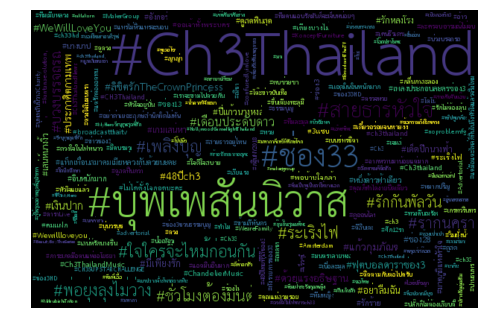

In [0]:
#sum_df.to_dict()
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wd=WordCloud(font_path='THSarabunNew.ttf',width=600, height=400).generate_from_frequencies(sum_df.to_dict())
plt.imshow(wd, interpolation='bilinear')
plt.axis("off")